# Imports

In [1]:
# common / KNN imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.spatial.distance
from collections import Counter
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
plt.set_cmap('gray')

## Load Datasets / Subset functions

In [2]:
#-----------------------------------------------
# Load MNIST Data
#-----------------------------------------------
mnist_data = tf.keras.datasets.mnist.load_data()

# Get Training set
train = mnist_data[0]
x_mnist_train_full, y_mnist_train_full = train[0], train[1]

# Get Test set
test = mnist_data[1]
x_mnist_test_full, y_mnist_test_full = test[0], test[1]

n_mnist_train = x_mnist_train_full.shape[0]
n_mnist_test =x_mnist_test_full.shape[0]

m = x_mnist_train_full.shape[1]**2

x_mnist_train_full = x_mnist_train_full.reshape([n_mnist_train, m])
x_mnist_test_full = x_mnist_test_full.reshape([n_mnist_test, m])


In [57]:
#-----------------------------------------------
# Create MNIST Subset
#-----------------------------------------------

# Create train subset
idx = np.random.randint(n_mnist_train, size= 1000)
x_mnist_train = x_mnist_train_full[idx]
y_mnist_train = y_mnist_train_full[idx]

# Create test subset
idx = np.random.randint(n_mnist_test, size= 30)
x_mnist_test = x_mnist_test_full[idx]
y_mnist_test = y_mnist_test_full[idx]

def set_mnist_subsets(train_size, test_size):
    global n_mnist_train
    global n_mnist_test
    global x_mnist_train
    global y_mnist_train
    global x_mnist_test
    global y_mnist_test
    
    idx = np.random.randint(n_mnist_train, size= train_size)
    x_mnist_train = x_mnist_train_full[idx]
    y_mnist_train = y_mnist_train_full[idx]
    idx = np.random.randint(n_mnist_test, size= test_size)
    x_mnist_test = x_mnist_test_full[idx]
    y_mnist_test = y_mnist_test_full[idx]

print(x_mnist_test.shape)
print(y_mnist_test.shape)
print(x_mnist_train.shape)
print(y_mnist_train.shape)
print(y_mnist_train[1])

(30, 784)
(30,)
(1000, 784)
(1000,)
4


In [56]:
#-----------------------------------------------
# Load CIFAR data
#-----------------------------------------------

cifar = tf.keras.datasets.cifar10.load_data()[0]
x_cifar, y_cifar = cifar[0], cifar[1]

# Convert to grayscale
x_cifar = np.dot(x_cifar[...,:3], [0.299, 0.587, 0.114])
print(x_cifar.shape)

n_x_cifar = x_cifar.shape[0]
m_x_cifar = x_cifar.shape[1]**2

x_cifar = x_cifar.reshape([n_x_cifar, m_x_cifar])


(50000, 32, 32)


In [5]:
#-----------------------------------------------
# Create Cifar Subset
#-----------------------------------------------
idx = np.random.randint(n_x_cifar, size=1030)
x_cifar_sample = x_cifar[idx]
y_cifar_sample = y_cifar[idx]

# Create test & train set
x_cifar_test = x_cifar_sample[:30]
y_cifar_test = y_cifar_sample[:30,0]

x_cifar_train = x_cifar_sample[30:]
y_cifar_train = y_cifar_sample[30:,0]

def set_cifar_subsets(train_size, test_size):
    global n_x_cifar
    global x_cifar_train
    global y_cifar_train
    global x_cifar_test
    global y_cifar_test
    
    idx = np.random.randint(n_x_cifar, size= train_size + test_size)
    x_cifar_sample = x_cifar[idx]
    y_cifar_sample = y_cifar[idx]

    # Create test & train set
    x_cifar_test = x_cifar_sample[:test_size]
    y_cifar_test = y_cifar_sample[:test_size,0]

    x_cifar_train = x_cifar_sample[test_size:]
    y_cifar_train = y_cifar_sample[test_size:,0]


print(x_cifar_test.shape)
print(y_cifar_test.shape)
print(x_cifar_train.shape)
print(y_cifar_train.shape)
print(y_cifar_train[1])

(30, 1024)
(30,)
(1000, 1024)
(1000,)
9


## KNN Funktionen

In [20]:
def knn(k, x_train, y_train, x_test):
    dists = scipy.spatial.distance.cdist(x_train, x_test, metric='euclid')
    idx_nearest = np.argpartition(dists, k, axis=0)[:k]
    idx_nearest = np.swapaxes(idx_nearest, 0, 1)
    #print(idx_nearest)

    closest_points_labels = y_train[idx_nearest]
    y_test_predictions = []
    
    for index, predicted_labels in enumerate(closest_points_labels):
        y_test_predictions.append(np.bincount(predicted_labels).argmax())
    return y_test_predictions

In [21]:
def knn_print_error_rate(y_test,  y_test_predictions):
    
    correct = 0
    
    correct_labels = (y_test)
    
    numbers_count = Counter(correct_labels)
    
    numbers_correct = dict.fromkeys(numbers_count.keys(), 0)
    
    #numbers_error_rate = dict.fromkeys(numbers_count.keys(), None)
    
    
    n = correct_labels.shape[0]
    
    for index, prediction in enumerate( y_test_predictions):
        if prediction == correct_labels[index]:
            correct += 1
            numbers_correct[prediction] += 1
        
    error_rate = 1- (correct / n)
    
    
    for key in sorted(numbers_count):
        count = numbers_count[key]
        correct = numbers_correct[key]
        error = 1 - numbers_correct[key] / numbers_count[key]
        print("Label:", key)
        print("  ", correct, "out of", count, "recognized correctly | Errorrate:", error*100, "%")
        
    print("\n"+"Resulting errorrate:", error_rate*100, "%")

## K-means Funktionen

In [10]:
def kmeans_start(x_train, k):
   
    global g_color_map
    global g_embedding
    global g_centroids
    global g_labels
    global g_x_train
    global g_k
    
    kmeans_number_of_classes = k
    
    color_map = sns.color_palette("hls", k)
    _tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    embedding = _tsne.fit_transform(x_train)

    # init centroids
    idx_centroid = np.random.randint(x_train.shape[0], size=k)
    centroids = x_train[idx_centroid]
    
    # calc distances
    dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
    
    # find nearest centroids
    labels = np.argmin(dists, axis=1)
    
    kmeans_training_set = x_train
    
    g_color_map = color_map
    g_embedding = embedding
    g_centroids = centroids
    g_labels = labels
    g_x_train = x_train
    g_k = k

In [11]:
def kmeans_train(it, y_train):
    
    global g_color_map
    global g_embedding
    global g_centroids
    global g_labels
    global g_x_train
    global g_k
    
    color_map =  g_color_map
    embedding = g_embedding
    centroids =  g_centroids
    labels = g_labels
    x_train = g_x_train
    k =  g_k
    
    # train model for q iterations
    for j in range(it):
        
        # calc distances
        dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
        
        # label according to nearest centroids
        labels = np.argmin(dists, axis=1)
        
        # get new centroids
        centroid_list = [x_train[labels == i].mean(0) for i in range(k)]
        centroids = np.stack(centroid_list)
        
        
        # print results

    for i in range(k):
    
        size = y_train[labels == i].shape[0]
        bincount = np.bincount(y_train[labels == i])
        mode = bincount.argmax()
        correct = bincount[mode]
        percentage = correct / size
        print()
        print(i+1, "| Mayority:", mode)
        print("-------------------------------------")
        print("correct:", correct, "| size:", size)
        print("Percentage of majority class:", percentage*100, "%", "\n")
        
        colors = [color_map[l] for l in labels]
        plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

# Aufgaben

## A KNN

### How many distances you need to calculate if you have 60,000 samples in the trainingset for 50 samples?
<p> Man muss 3.000.000 Abstände berechnen. </p>

### How many distances do you need to calculate if you have n samples im the trainingset?
<p> Man muss immer n * 50 Abstände berechnen, d.h. bei 3 Samples müsste man 150 Abstände berechnen, bei 90.000 dann 4.500.000 </p>

## B KNN

In [26]:
set_mnist_subsets(50000,1000)

In [27]:
predictions2 = knn(2, x_mnist_train, y_mnist_train, x_mnist_test)
predictions4 = knn(4, x_mnist_train, y_mnist_train, x_mnist_test)
predictions8 = knn(8, x_mnist_train, y_mnist_train, x_mnist_test)

print(list(y_mnist_test), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
knn_print_error_rate(y_mnist_test, predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
knn_print_error_rate(y_mnist_test, predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
knn_print_error_rate(y_mnist_test,predictions8)


[6, 3, 5, 4, 4, 6, 0, 8, 7, 5, 8, 1, 0, 6, 3, 7, 1, 0, 7, 0, 1, 8, 4, 8, 9, 1, 2, 7, 4, 3, 8, 7, 8, 5, 8, 8, 3, 2, 4, 5, 5, 4, 3, 4, 4, 3, 2, 2, 5, 3, 8, 7, 9, 2, 1, 0, 9, 7, 0, 3, 4, 9, 7, 8, 3, 2, 2, 5, 3, 7, 3, 1, 1, 6, 2, 2, 3, 8, 0, 4, 9, 7, 8, 6, 3, 9, 5, 1, 0, 9, 1, 1, 2, 2, 5, 9, 6, 8, 7, 0, 7, 9, 1, 0, 8, 3, 6, 7, 1, 6, 1, 2, 0, 2, 2, 7, 3, 6, 2, 4, 9, 7, 9, 0, 6, 5, 8, 6, 1, 9, 4, 5, 3, 3, 2, 6, 0, 2, 4, 0, 0, 0, 6, 7, 2, 1, 4, 2, 1, 7, 0, 5, 9, 4, 1, 7, 7, 5, 5, 9, 9, 9, 7, 1, 9, 0, 7, 5, 5, 9, 6, 3, 4, 6, 3, 0, 5, 6, 8, 1, 2, 0, 7, 8, 0, 6, 6, 7, 6, 0, 4, 9, 0, 2, 5, 3, 0, 8, 6, 3, 3, 6, 1, 0, 6, 9, 1, 1, 2, 0, 4, 1, 9, 1, 9, 3, 5, 4, 6, 7, 2, 5, 7, 1, 3, 4, 1, 5, 7, 5, 1, 4, 4, 6, 1, 7, 4, 9, 9, 4, 5, 0, 9, 6, 2, 2, 9, 2, 1, 2, 3, 4, 2, 4, 7, 7, 7, 5, 4, 7, 3, 5, 8, 9, 8, 2, 7, 3, 4, 5, 1, 8, 1, 3, 6, 8, 5, 0, 9, 1, 1, 6, 2, 7, 8, 2, 9, 3, 1, 6, 9, 0, 9, 3, 1, 8, 6, 2, 9, 5, 0, 0, 3, 7, 1, 2, 4, 8, 3, 1, 6, 5, 9, 9, 7, 6, 8, 6, 7, 7, 9, 3, 3, 4, 8, 7, 8, 1, 0, 3, 7, 9, 2, 

### What is the error rate of KNN on the test set?

Die Errorrate beim ersten Testen (mit k=2, train = 10.000, test = 30) war 6%.  
Beim testen mit neuen subsets gab es auch Errorraten zwischen 3 - 16%
<p>Die Errorate ändert sich jedes mal nachdem neue subsets erzeugt werden. Dies liegt daran, dass die subsets random gewählt werden und manche besser für knn geeignet sind als andere. Zum Beispiel weil es von allen labels gleich viele im Test Set gibt</p>

### What is the error rate for each label (number)?
Die Errorraten beim ersten Testen (mit k=2) waren:
* 0 - 0.0%
* 1 - 0.0%
* 2 - 0.0%
* 3 - 0.0%
* 4 - 33.0% (2/3)
* 5 - 20.0% (4/5)
* 6 - 0.0%
* 7 - 0.0%
* 8 - 0.0%
* 9 - 0.0%

### How does the choice of k influence the result?
Beim ersten Testen hat sich die Errorrate mit zunehmendem k verbessert:

* k = 2: 4.5%
* k = 4: 4.4%
* k = 8: 4.7%  
  
Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nicht immer auf die Errorquote auswirkt, aber k=4 tendenziell niedrigere Errorraten für unsere Test- und Traingrößen hatte.

## C K-means MNIST

In [51]:
set_mnist_subsets(5000,50)
k_mnist = 10
kmeans_start(x_mnist_train, k_mnist)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.215s...
[t-SNE] Computed neighbors for 5000 samples in 35.841s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 473.134825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.502342
[t-SNE] KL divergence after 300 iterations: 2.140753



1 | Mayority: 4
-------------------------------------
correct: 167 | size: 420
Percentage of majority class: 39.76190476190476 % 


2 | Mayority: 1
-------------------------------------
correct: 247 | size: 389
Percentage of majority class: 63.49614395886889 % 


3 | Mayority: 7
-------------------------------------
correct: 142 | size: 509
Percentage of majority class: 27.897838899803535 % 


4 | Mayority: 0
-------------------------------------
correct: 356 | size: 382
Percentage of majority class: 93.19371727748691 % 


5 | Mayority: 7
-------------------------------------
correct: 247 | size: 268
Percentage of majority class: 92.16417910447761 % 


6 | Mayority: 6
-------------------------------------
correct: 421 | size: 804
Percentage of majority class: 52.363184079601986 % 


7 | Mayority: 1
-------------------------------------
correct: 314 | size: 540
Percentage of majority class: 58.14814814814815 % 


8 | Mayority: 3
-------------------------------------
correct: 344 | size

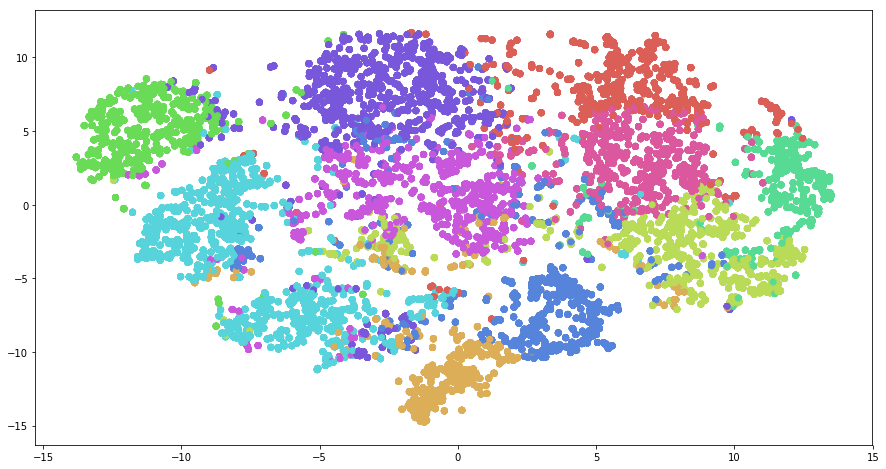

In [54]:
itr_means = 900
kmeans_train(itr_means, y_mnist_train)

## Legende
* 1: Rot
* 2: Gold
* 3: Neongelb
* 4: Hellgrün
* 5: Türkis
* 6: Hellblau
* 7: Blau
* 8: Sehr Dunkel Lila
* 9: Lila
* 10: Hell Lila (ähnlich zu rot)

### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>

Ergebniss von einem der Trainingsset (size = 5000)

| Group | k=10  | k=100 | k=1000 |
|-------|-------|-------|--------|
| 1     | 4 44% | 4 40% | 4 40%  |
| 2     | 1 72% | 1 63% | 1 63%  |
| 3     | 4 27% | 7 28% | 7 28%  |
| 4     | 0 92% | 0 93% | 0 93%  |
| 5     | 7 92% | 7 92% | 7 92%  |
| 6     | 6 55% | 6 52% | 6 52%  |
| 7     | 1 45% | 1 58% | 1 58%  |
| 8     | 3 50% | 3 51% | 3 51%  |
| 9     | 8 41% | 8 47% | 8 47%  |
| 10    | 9 38% | 9 46% | 9 46%  |


### Does each number have a cluster?
<p> Nein. Dies könnte vielleicht daran liegen, dass der Datensatz nicht ausgeglichen ist (Jedes Label ist nicht gleih häufig vertreten) / die zufällig gewälten Centroiden ungünstig gewählt waren. </p>

### If not, which hasn’t?

| k    | Nicht vertreten |
|------|-----------------|
| 10   | 2, 5            |
| 100  | 2, 5            |
| 1000 | 2, 5            |

## D MNIST understanding

##### Some numbers are more difficult to predict with KNN and to cluster with K-means. Show why.  Start with examples, and get more general

## E KNN and K-means CIFAR

### transform cifar-10 to grayscale.
Siehe oben beim Laden von CIFAR

## Demonstrate this similar to B, C and D

## E.B KNN

In [14]:
set_cifar_subsets(10000,50)

In [15]:
predictions2 = knn(2, x_cifar_train, y_cifar_train, x_cifar_test)
predictions4 = knn(4, x_cifar_train, y_cifar_train, x_cifar_test)
predictions8 = knn(8, x_cifar_train, y_cifar_train, x_cifar_test)

print(list(y_cifar_test), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
knn_print_error_rate(y_cifar_test, predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
knn_print_error_rate(y_cifar_test, predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
knn_print_error_rate(y_cifar_test,predictions8)


[1, 7, 1, 9, 2, 1, 4, 3, 4, 9, 1, 2, 6, 1, 8, 7, 4, 9, 6, 7, 0, 9, 3, 3, 8, 5, 2, 6, 6, 8, 3, 1, 7, 4, 3, 4, 6, 2, 3, 2, 7, 7, 6, 8, 4, 5, 2, 3, 3, 3] 

-------------------------------------
  2NN  
-------------------------------------
Predictions:
[3, 0, 3, 8, 4, 2, 8, 4, 0, 4, 0, 2, 3, 6, 0, 5, 0, 4, 6, 6, 0, 5, 0, 3, 4, 0, 0, 4, 4, 8, 3, 0, 4, 4, 3, 2, 0, 0, 3, 0, 5, 2, 0, 8, 0, 5, 2, 3, 3, 5] 

Label: 0
   1 out of 1 recognized correctly | Errorrate: 0.0 %
Label: 1
   0 out of 6 recognized correctly | Errorrate: 100.0 %
Label: 2
   2 out of 6 recognized correctly | Errorrate: 66.66666666666667 %
Label: 3
   6 out of 9 recognized correctly | Errorrate: 33.333333333333336 %
Label: 4
   1 out of 6 recognized correctly | Errorrate: 83.33333333333334 %
Label: 5
   1 out of 2 recognized correctly | Errorrate: 50.0 %
Label: 6
   1 out of 6 recognized correctly | Errorrate: 83.33333333333334 %
Label: 7
   0 out of 6 recognized correctly | Errorrate: 100.0 %
Label: 8
   2 out of 4 recogniz

### What is the error rate of KNN on the test set?

Die Errorrate beim ersten Testen (mit k=2, train = 10.000, test = 30) war 6%.  
Beim testen mit neuen subsets gab es auch Errorraten zwischen 3 - 16%
<p>Die Errorate ändert sich jedes mal nachdem neue subsets erzeugt werden. Dies liegt daran, dass die subsets random gewählt werden und manche besser für knn geeignet sind als andere. Zum Beispiel weil es von allen labels gleich viele im Test Set gibt</p>

### What is the error rate for each label (number)?
Die Errorraten beim ersten Testen (mit k=2) waren:
* 0 - 0.0%
* 1 - 0.0%
* 2 - 0.0%
* 3 - 0.0%
* 4 - 33.0% (2/3)
* 5 - 20.0% (4/5)
* 6 - 0.0%
* 7 - 0.0%
* 8 - 0.0%
* 9 - 0.0%

### How does the choice of k influence the result?
Beim ersten Testen hat sich die Errorrate mit zunehmendem k verbessert:

* k = 2: 4.5%
* k = 4: 4.4%
* k = 8: 4.7%  
  
Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nicht immer auf die Errorquote auswirkt, aber k=4 tendenziell niedrigere Errorraten für unsere Test- und Traingrößen hatte.

### Does knn work similarly good?

## E.C K-means CIFAR

In [16]:
set_cifar_subsets(1000,30)
k_cifar = 10
kmeans_start(x_cifar_train, k_cifar)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.056s...
[t-SNE] Computed neighbors for 1000 samples in 2.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 476.805254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.640228
[t-SNE] KL divergence after 300 iterations: 1.994978



1 | Mayority: 4
-------------------------------------
correct: 18 | size: 132
Percentage of majority class: 13.636363636363635 % 


2 | Mayority: 8
-------------------------------------
correct: 5 | size: 19
Percentage of majority class: 26.31578947368421 % 


3 | Mayority: 9
-------------------------------------
correct: 25 | size: 109
Percentage of majority class: 22.93577981651376 % 


4 | Mayority: 0
-------------------------------------
correct: 12 | size: 44
Percentage of majority class: 27.27272727272727 % 


5 | Mayority: 0
-------------------------------------
correct: 15 | size: 99
Percentage of majority class: 15.151515151515152 % 


6 | Mayority: 4
-------------------------------------
correct: 15 | size: 83
Percentage of majority class: 18.072289156626507 % 


7 | Mayority: 7
-------------------------------------
correct: 16 | size: 84
Percentage of majority class: 19.047619047619047 % 


8 | Mayority: 6
-------------------------------------
correct: 32 | size: 165
Percen

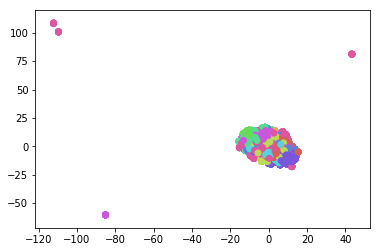

In [17]:
itr_means = 1000
kmeans_train(itr_means, y_cifar_train)

### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>

Ergebniss von einem der Trainingsset (size = 5000)

| Group | k=10  | k=100 | k=1000 |
|-------|-------|-------|--------|
| 1     | 4 44% | 4 40% | 4 40%  |
| 2     | 1 72% | 1 63% | 1 63%  |
| 3     | 4 27% | 7 28% | 7 28%  |
| 4     | 0 92% | 0 93% | 0 93%  |
| 5     | 7 92% | 7 92% | 7 92%  |
| 6     | 6 55% | 6 52% | 6 52%  |
| 7     | 1 45% | 1 58% | 1 58%  |
| 8     | 3 50% | 3 51% | 3 51%  |
| 9     | 8 41% | 8 47% | 8 47%  |
| 10    | 9 38% | 9 46% | 9 46%  |


### Does each number have a cluster?
<p> Nein. Dies könnte vielleicht daran liegen, dass der Datensatz nicht ausgeglichen ist (Jedes Label ist nicht gleih häufig vertreten) / die zufällig gewälten Centroiden ungünstig gewählt waren. </p>

### If not, which hasn’t?

| k    | Nicht vertreten |
|------|-----------------|
| 10   | 2, 5            |
| 100  | 2, 5            |
| 1000 | 2, 5            |

### Does k-means work similarly good?

## F Linear regression BOSTON

Train a linear regression model on the BOSTON dataset to predict median
values of houses. Test it on the test set. Show the code how you did it! What
dependent variables (columns) have the biggest influence?

 RM and lstat have the biggest influence 


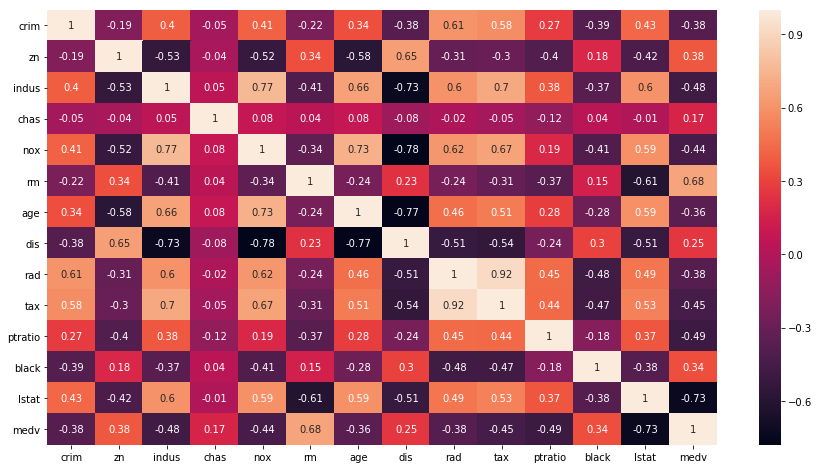

In [18]:
plt.rcParams['figure.figsize'] = [15, 8]

np.set_printoptions(suppress=True)

boston = tf.keras.datasets.boston_housing.load_data()[0]
X = boston[0]
Y = boston[1]


c = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", 'medv']
boston = pd.DataFrame({c: X[:, i] for i, c in enumerate(c[:-1])})
boston[c[-1]] = Y
#add median 
np.median(boston)

boston.head()

#Correlation Matrix
correlation_matrix = boston.corr().round(2)

sns.heatmap(data= correlation_matrix, annot=True)

print(" RM and lstat have the biggest influence ")

###Select target variable 

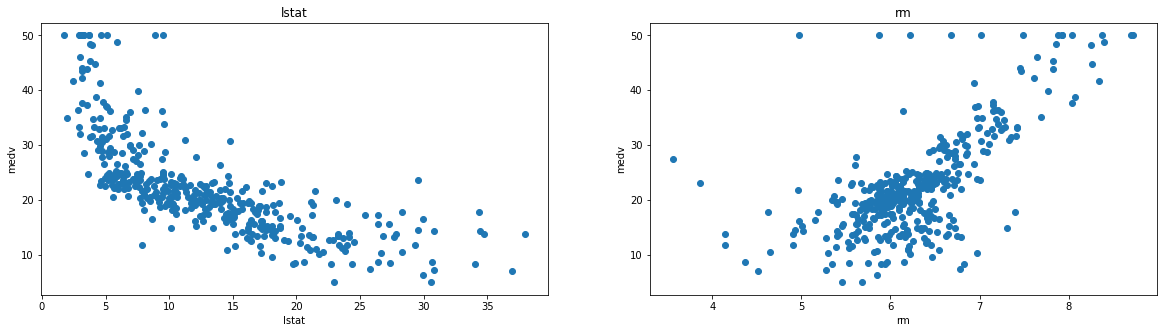

In [19]:
plt.figure(figsize=(20, 5))

features = ['lstat', 'rm']
target = boston['medv']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('medv')

## G Logistik regression MNIST

Evalute logistic regression as B and D on MNIST

## H Feedback

How much time did you work on this assignment and how often did you
meet?
* Did you use Google Colab or Anaconda?
* What was your favourite excercise? Why?
* What excercise did you like least? Why?